# Fashion-MNIST Notebook

## Original Model Definition

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import os
import matplotlib.pyplot as plt

from torch.ao.quantization.fake_quantize import FakeQuantize
from torch.ao.quantization.observer import HistogramObserver, MovingAverageMinMaxObserver, MovingAveragePerChannelMinMaxObserver
from torch.ao.quantization.qconfig import QConfig
import torch.ao.quantization as quantization

In [2]:
batch_size = 64
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(root='./Fashion-MNIST/data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./Fashion-MNIST/data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
class FashionNN(nn.Module):
    def __init__(self):
        super(FashionNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        return out

In [4]:
def train(optimizer, criteria, epoch, log_interval=((len(train_loader.dataset)/batch_size)/2)-1):
    model.train()
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(images)
        loss = criteria(output, labels)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(images), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

def validate():
    model.eval()
    
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            output = model(images)
            predicted = output.data.max(1, keepdim=True)[1]
            correct += predicted.eq(labels.data.view_as(predicted)).sum()

    print('\nValidation Set Accuracy: {}/{} ({:.2f}%)\n'.format(correct, len(val_loader.dataset), 100. * correct / len(val_loader.dataset)))

In [5]:
model = FashionNN()

criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    train(optimizer, criteria, epoch)
    validate()

/home/brais.martinez/.local/lib/python3.10/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Epoch: 0 [0/48000 (0%)]	Loss: 2.323547
Train Epoch: 0 [23936/48000 (50%)]	Loss: 0.350894
Train Epoch: 0 [47872/48000 (100%)]	Loss: 0.256623

Validation Set Accuracy: 10669/12000 (88.91%)

Train Epoch: 1 [0/48000 (0%)]	Loss: 0.241340
Train Epoch: 1 [23936/48000 (50%)]	Loss: 0.240040
Train Epoch: 1 [47872/48000 (100%)]	Loss: 0.232930

Validation Set Accuracy: 10798/12000 (89.98%)

Train Epoch: 2 [0/48000 (0%)]	Loss: 0.199972
Train Epoch: 2 [23936/48000 (50%)]	Loss: 0.282907
Train Epoch: 2 [47872/48000 (100%)]	Loss: 0.216578

Validation Set Accuracy: 10766/12000 (89.72%)

Train Epoch: 3 [0/48000 (0%)]	Loss: 0.272960
Train Epoch: 3 [23936/48000 (50%)]	Loss: 0.242984
Train Epoch: 3 [47872/48000 (100%)]	Loss: 0.225624

Validation Set Accuracy: 10968/12000 (91.40%)

Train Epoch: 4 [0/48000 (0%)]	Loss: 0.149722
Train Epoch: 4 [23936/48000 (50%)]	Loss: 0.241193
Train Epoch: 4 [47872/48000 (100%)]	Loss: 0.176599

Validation Set Accuracy: 10929/12000 (91.07%)

Train Epoch: 5 [0/48000 (0%)]	

In [6]:
def test(network, criteria):
    network.eval()
    
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            output = network(images)
            test_loss += criteria(output, labels).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(labels.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 0100. * correct / len(test_loader.dataset)))

torch.save(model.state_dict() , './models/FashionMNIST/original_model.pth')
test(model, criteria)


Test set: Avg. loss: 0.004613, Accuracy: 9060/10000 (90.60%)



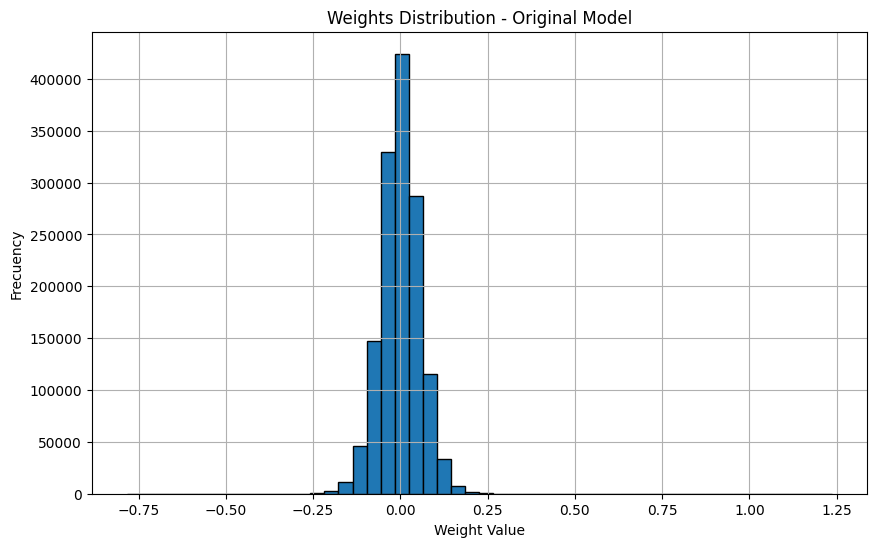

In [7]:
def show_weights(network, name):
    weights = []
    for param in network.parameters():
        if param.requires_grad:
            weights.extend(param.detach().cpu().numpy().flatten())
    
    plt.figure(figsize=(10, 6))
    plt.hist(weights, bins=50, edgecolor='black')
    plt.title('Weights Distribution - {}'.format(name))
    plt.xlabel('Weight Value')
    plt.ylabel('Frecuency')
    plt.grid(True)
    plt.show()

show_weights(model,"Original Model")

## Pytorch Post-Training Quantization (8 bits)

In [8]:
ptq_model_8bit = torch.quantization.quantize_dynamic(model, {nn.Linear, nn.Conv2d, nn.BatchNorm2d, nn.MaxPool2d}, dtype=torch.qint8)
torch.save(ptq_model_8bit.state_dict(), './models/FashionMNIST/ptq_model_8bit.pth')

In [9]:
float_model_size = os.path.getsize('./models/FashionMNIST/original_model.pth') / 1024**2
quant_model_size = os.path.getsize('./models/FashionMNIST/ptq_model_8bit.pth') / 1024**2

print("Float model: {:.3f}MB".format(float_model_size))
print("Quantized model: {:.3f}MB".format(quant_model_size))

Float model: 5.378MB
Quantized model: 1.407MB


In [10]:
test(ptq_model_8bit, criteria)


Test set: Avg. loss: 0.004619, Accuracy: 9053/10000 (90.53%)



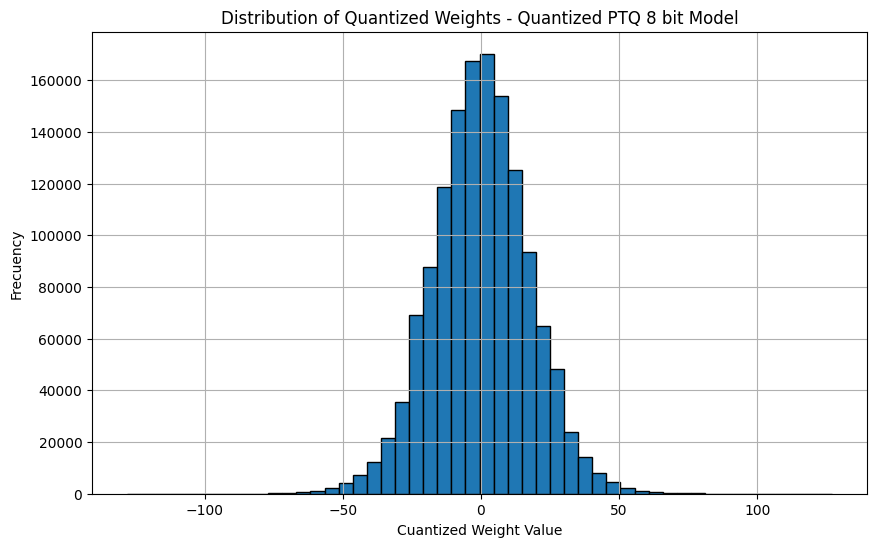

In [11]:
def show_quantized_weights(network, title):
    weights = []
    for name, module in network.named_modules():
        if isinstance(module, torch.nn.quantized.Linear) or isinstance(module, torch.nn.quantized.Conv2d):
            weight = module.weight()
            weights.extend(weight.int_repr().flatten().cpu().numpy())
    plt.figure(figsize=(10, 6))
    plt.hist(weights, bins=50, edgecolor='black')
    plt.title('Distribution of Quantized Weights - {}'.format(title))
    plt.xlabel('Cuantized Weight Value')
    plt.ylabel('Frecuency')
    plt.grid(True)
    plt.show()

show_quantized_weights(ptq_model_8bit,"Quantized PTQ 8 bit Model")

## Pytorch Quantization Aware Training (8 bits)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import os
import matplotlib.pyplot as plt

from torch.ao.quantization.fake_quantize import FakeQuantize
from torch.ao.quantization.observer import HistogramObserver, MovingAverageMinMaxObserver, MovingAveragePerChannelMinMaxObserver
from torch.ao.quantization.qconfig import QConfig
import torch.ao.quantization as quantization

In [13]:
class QuantAwareFashionNN(nn.Module):
    def __init__(self):
        super(QuantAwareFashionNN, self).__init__()
        self.quant = quantization.QuantStub()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        self.dequant = quantization.DeQuantStub()
        
    def forward(self, x):
        x = self.quant(x)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.dequant(out)
        return out

In [14]:
batch_size = 64
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(root='./Fashion-MNIST/data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./Fashion-MNIST/data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
qat_model_8bit = QuantAwareFashionNN()

qat_model_8bit.train()
qat_model_8bit.qconfig = quantization.get_default_qat_qconfig('x86')
qat_model_8bit = quantization.prepare_qat(qat_model_8bit)

/home/brais.martinez/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:221: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [16]:
def train(optimizer, criteria, epoch, log_interval=((len(train_loader.dataset)/batch_size)/2)-1):
    qat_model_8bit.train()
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        output = qat_model_8bit(images)
        loss = criteria(output, labels)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(images), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

def validate():
    qat_model_8bit.eval()
    
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            output = qat_model_8bit(images)
            predicted = output.data.max(1, keepdim=True)[1]
            correct += predicted.eq(labels.data.view_as(predicted)).sum()

    print('\nValidation Set Accuracy: {}/{} ({:.2f}%)\n'.format(correct, len(val_loader.dataset), 100. * correct / len(val_loader.dataset)))

In [ ]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(qat_model_8bit.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    train(optimizer, criteria, epoch)
    validate()

Train Epoch: 0 [0/48000 (0%)]	Loss: 2.349167
Train Epoch: 0 [23936/48000 (50%)]	Loss: 1.779843
Train Epoch: 0 [47872/48000 (100%)]	Loss: 4.947837

Validation Set Accuracy: 8383/12000 (69.86%)

Train Epoch: 1 [0/48000 (0%)]	Loss: 18.645187
Train Epoch: 1 [23936/48000 (50%)]	Loss: 1.362560
Train Epoch: 1 [47872/48000 (100%)]	Loss: 0.656857

Validation Set Accuracy: 10012/12000 (83.43%)

Train Epoch: 2 [0/48000 (0%)]	Loss: 0.293116
Train Epoch: 2 [23936/48000 (50%)]	Loss: 0.367632
Train Epoch: 2 [47872/48000 (100%)]	Loss: 0.577354

Validation Set Accuracy: 10448/12000 (87.07%)

Train Epoch: 3 [0/48000 (0%)]	Loss: 0.429460
Train Epoch: 3 [23936/48000 (50%)]	Loss: 0.838420
Train Epoch: 3 [47872/48000 (100%)]	Loss: 0.636501

Validation Set Accuracy: 10452/12000 (87.10%)

Train Epoch: 4 [0/48000 (0%)]	Loss: 0.390725
Train Epoch: 4 [23936/48000 (50%)]	Loss: 0.491411
Train Epoch: 4 [47872/48000 (100%)]	Loss: 0.089202

Validation Set Accuracy: 10485/12000 (87.38%)

Train Epoch: 5 [0/48000 (0%)]	

In [ ]:
qat_model_8bit.eval()
qat_model_8bit = quantization.convert(qat_model_8bit)

torch.save(qat_model_8bit.state_dict() , './models/FashionMNIST/qat_model_8bit.pth')
test(qat_model_8bit, criteria)

In [ ]:
float_model_size = os.path.getsize('./models/FashionMNIST/original_model.pth') / 1024**2
quant_model_size = os.path.getsize('./models/FashionMNIST/qat_model_8bit.pth') / 1024**2

print("Float model: {:.3f}MB".format(float_model_size))
print("Quantized model: {:.3f}MB".format(quant_model_size))

In [ ]:
show_quantized_weights(qat_model_8bit,"Quantized QAT 8 bit Model")

## Post-Training Quantization propio (4 bits) (simulados)

In [ ]:
def quantize_weights(tensor, bits):
    min_val, max_val = tensor.min(), tensor.max()
    scale = (max_val - min_val) / ((2**bits)- 1)
    quantized_tensor = torch.round((tensor) / scale)
    return quantized_tensor

def quantize_model(model, bits = 4): #TODO: IN PROGRESS
    quantized_model = FashionNN()

    for name, param in model.named_parameters():
        if 'weight' in name:
            quantized_param = quantize_weights(param.data, bits)
            try:
                layer_name, param_type = name.split('.')
                _ = ''
            except:
                layer_name, _, param_type = name.split('.')
            layer = getattr(quantized_model, layer_name)
            if isinstance(getattr(layer, _, param_type), torch.nn.modules.conv.Conv2d) or isinstance(getattr(layer, _, param_type), torch.nn.modules.batchnorm.BatchNorm2d) or isinstance(getattr(layer, param_type), torch.Tensor):
                setattr(layer, param_type, nn.Parameter(quantized_param))
            else:
                raise ValueError(f"Expected {param_type} to be a tensor, but got {type(getattr(layer, _, param_type))} instead.")
        else:
            try:
                layer_name, param_type = name.split('.')
                _ = ''
            except:
                layer_name, _, param_type = name.split('.')
            layer = getattr(quantized_model, layer_name)
            setattr(layer, param_type, nn.Parameter(param.data))

    return quantized_model

In [ ]:
ptq_model_4bit = quantize_model(model,4)

torch.save(ptq_model_4bit.state_dict(), 'models/FashionMNIST/ptq_model_4bit_sim.pth')
test(ptq_model_4bit, criteria)

In [ ]:
def show_weights(network, name):
    weights = []
    for param in network.parameters():
        if param.requires_grad:
            weights.extend(param.detach().cpu().numpy().flatten())
    
    plt.figure(figsize=(10, 6))
    plt.hist(weights, bins=50, edgecolor='black')
    plt.title('Weights Distribution - {}'.format(name))
    plt.xlabel('Weight Value')
    plt.ylabel('Frecuency')
    plt.grid(True)
    plt.show()

show_weights(ptq_model_4bit,"Quantized PTQ 4 bit Model")

## Quantization Aware Training propio (4 bits)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import os
import matplotlib.pyplot as plt

from torch.ao.quantization.fake_quantize import FakeQuantize
from torch.ao.quantization.observer import HistogramObserver, MovingAverageMinMaxObserver, MovingAveragePerChannelMinMaxObserver
from torch.ao.quantization.qconfig import QConfig
import torch.ao.quantization as quantization

In [ ]:
class QuantAwareFashionNN(nn.Module):
    def __init__(self):
        super(QuantAwareFashionNN, self).__init__()
        self.quant = quantization.QuantStub()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        self.dequant = quantization.DeQuantStub()
        
    def forward(self, x):
        x = self.quant(x)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.dequant(out)
        return out

In [ ]:
batch_size = 64
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(root='./Fashion-MNIST/data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./Fashion-MNIST/data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
bits = 4

act = FakeQuantize.with_args(observer=MovingAverageMinMaxObserver, quant_min=0, quant_max=int(2 ** bits - 1), dtype=torch.quint8, qscheme=torch.per_tensor_affine, reduce_range=False)
weights = FakeQuantize.with_args(observer=MovingAveragePerChannelMinMaxObserver, quant_min=int(-(2 ** bits) / 2), quant_max=int((2 ** bits) / 2 - 1), dtype=torch.qint8, qscheme=torch.per_channel_symmetric, reduce_range=False)

qat_model_4bit = QuantAwareFashionNN()

qat_model_4bit.qconfig = quantization.get_default_qat_qconfig('x86')
qat_model_4bit.qconfig = quantization.qconfig.QConfig(activation=act, weight=weights)
qat_model_4bit = quantization.prepare_qat(qat_model_4bit)

In [ ]:
def train(optimizer, criteria, epoch, log_interval=((len(train_loader.dataset)/batch_size)/2)-1):
    qat_model_4bit.train()
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        output = qat_model_4bit(images)
        loss = criteria(output, labels)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(images), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

def validate():
    qat_model_4bit.eval()
    
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            output = qat_model_4bit(images)
            predicted = output.data.max(1, keepdim=True)[1]
            correct += predicted.eq(labels.data.view_as(predicted)).sum()

    print('\nValidation Set Accuracy: {}/{} ({:.2f}%)\n'.format(correct, len(val_loader.dataset), 100. * correct / len(val_loader.dataset)))

In [ ]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(qat_model_4bit.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    train(optimizer, criteria, epoch)
    validate()

In [ ]:
qat_model_4bit.eval()
qat_model_4bit = quantization.convert(qat_model_4bit)

torch.save(qat_model_4bit.state_dict() , './models/FashionMNIST/qat_model_4bit.pth')
test(qat_model_4bit, criteria)

In [ ]:
float_model_size = os.path.getsize('./models/FashionMNIST/original_model.pth') / 1024**2
quant_model_size = os.path.getsize('./models/FashionMNIST/qat_model_4bit.pth') / 1024**2

print("Float model: {:.3f}MB".format(float_model_size))
print("Quantized model: {:.3f}MB".format(quant_model_size))

In [ ]:
show_quantized_weights(qat_model_4bit,"Quantized QAT 4 bit Model")